## Copied from https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb

In [1]:
# Based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb
import torch
from torch.autograd import Variable

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)


In [3]:
def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()
get_flatten_output()

torch.Size([2, 3200])

In [4]:
def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()
get_reshape_output()

torch.Size([2, 1, 28, 28])

In [5]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    

In [6]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [7]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [9]:
model = Model(2)

In [10]:
z, x_reconstructed = model(Variable(torch.rand(1,1,28,28)))
z.size(), x_reconstructed.size()

(torch.Size([1, 2]), torch.Size([1, 1, 28, 28]))

In [25]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def train(
    dataloader,
    z_dim=2,
    n_epochs=10,
    use_cuda=False,
    print_every=100,
    plot_every=500,
    loss='mmd',
    lambd=1
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    #print(model)
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            mmd = compute_mmd(true_samples, z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + lambd*mmd
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, loss is {:.5f}".format(
                    #nll.data[0], mmd.data[0]))
                    nll.data.item(),mmd.data.item()))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model

In [26]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./tmp/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Negative log likelihood is 0.25183, loss is 0.16592


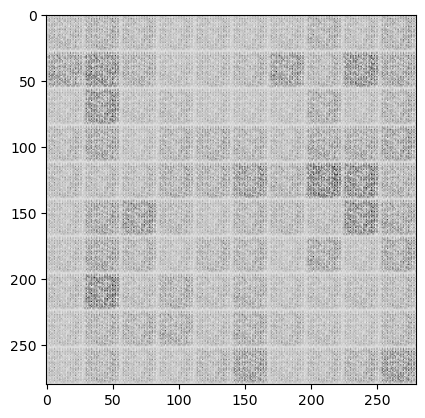

Negative log likelihood is 0.06817, loss is 0.97650
Negative log likelihood is 0.06730, loss is 1.01787
Negative log likelihood is 0.06929, loss is 0.99360
Negative log likelihood is 0.06767, loss is 1.00903
Negative log likelihood is 0.06860, loss is 0.96276


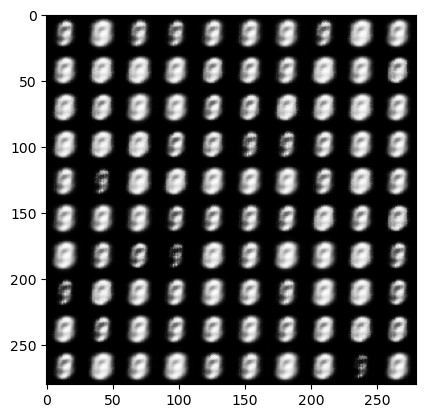

Negative log likelihood is 0.06735, loss is 0.99798
Negative log likelihood is 0.06529, loss is 1.06317
Negative log likelihood is 0.06915, loss is 0.95327
Negative log likelihood is 0.06535, loss is 1.10705
Negative log likelihood is 0.06956, loss is 1.06600


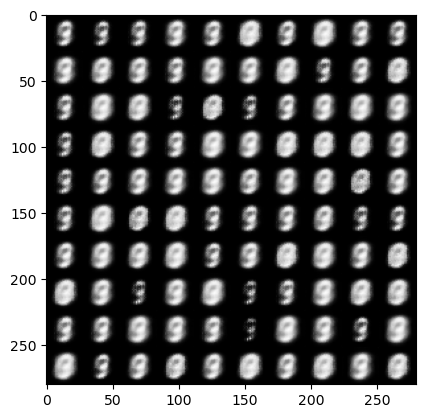

Negative log likelihood is 0.06749, loss is 1.02638
Negative log likelihood is 0.06682, loss is 0.89752
Negative log likelihood is 0.06483, loss is 0.95044
Negative log likelihood is 0.06608, loss is 0.95547
Negative log likelihood is 0.05954, loss is 0.98217


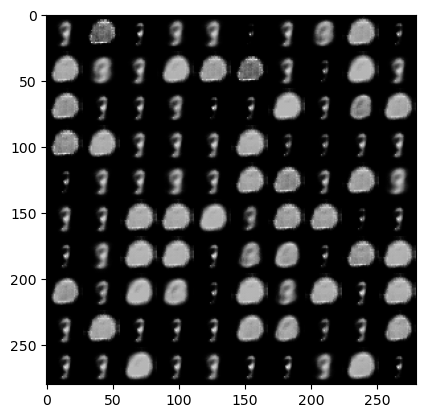

Negative log likelihood is 0.06093, loss is 1.02637
Negative log likelihood is 0.05881, loss is 1.10324
Negative log likelihood is 0.05745, loss is 0.85338
Negative log likelihood is 0.05509, loss is 0.94636
Negative log likelihood is 0.05331, loss is 1.17255


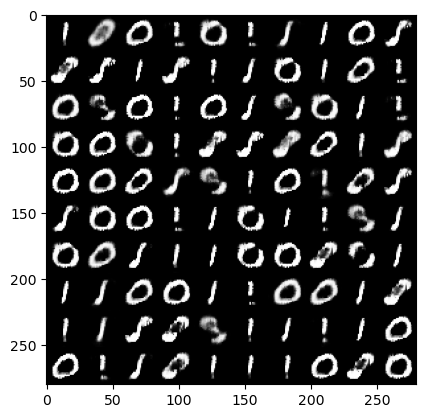

Negative log likelihood is 0.04932, loss is 1.05878
Negative log likelihood is 0.05187, loss is 0.92358
Negative log likelihood is 0.04859, loss is 0.91858
Negative log likelihood is 0.04884, loss is 0.88711


In [ ]:
z_dim = 2
model = train(mnist_train, z_dim=z_dim, n_epochs=10, loss='mmd',lambd=1)


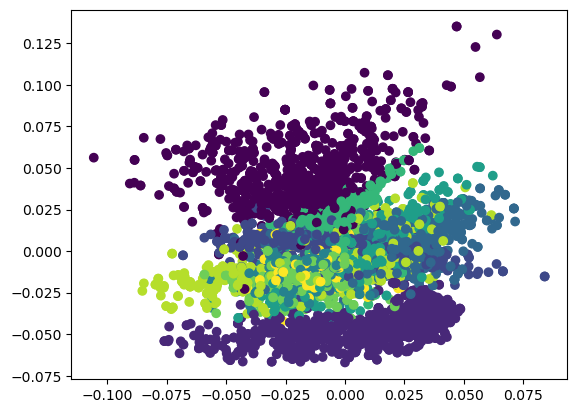

In [12]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = next(iter(mnist_test))
        #batch_x, batch_y = iter(mnist_test).next()
        #batch_x = Variable(batch_x, requires_grad=False).cuda()
        batch_x = Variable(batch_x, requires_grad=False)
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()